The goal here is to compare methods which fit data with psychometric curves using logistic regression. Indeed, after (long) experiments where for instance you collected sequences of keypresses, it is important to infer at best the parameters of the underlying processes: was the observer biased, or more precise? 

While I was *forevever* using [sklearn](https://scikit-learn.org/stable/index.html) or [lmfit](https://lmfit.github.io/lmfit-py/) (that is, scipy's [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)) and praised these beautifully crafted methods, I sometimes lacked some flexibility in the definition of the model. This notebook was done in collaboration with [Jenna Fradin](https://github.com/jennafradin), master student in the lab.

> tl; dr = Do not trust the coefficients extracted by a fit without validating for *methodological* biases.

One part of flexibility I missed is taking care of the *lapse rate*, that is the frequency with which you just *miss the key*. In a psychology experiment, you often see a fast sequence of trials for which you have to make a perceptual deccision, for instance press the Left or Right arrows. Sometimes you know the answer you should have done, but press the wrong eror. This error of distraction is always low (in the order of 5% to 10%) but could potentially change the results of the experiments. This is one of the aspects we will evaluate here.

In this notebook, I define a fitting method using [pytorch](https://pytorch.org/) which fits in a few lines of code :

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2, theta0=0, log_wt=torch.log(0.1*torch.ones(1))):
        super(LogisticRegressionModel, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.theta0 = torch.nn.Parameter(theta0 * torch.ones(1))
        self.logit0 = torch.nn.Parameter(logit0 * torch.ones(1))
        self.log_wt = torch.nn.Parameter(log_wt * torch.ones(1))

    def forward(self, theta):
        p0 = torch.sigmoid(self.logit0)
        #out = p0 / 2 + (1 - p0) * torch.sigmoid(self.linear(theta))
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-self.theta0 )/torch.exp(self.log_wt))
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(
    theta,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    logistic_model = LogisticRegressionModel()
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad)
    # optimizer = torch.optim.SGD(logistic_model.parameters(), lr=learning_rate)
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for Theta_, labels_ in loader:
            Theta_, labels_ = Theta_.to(device), labels_.to(device)
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    logistic_model.eval()
    Theta, labels = torch.Tensor(theta[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

and run a series of tests to compare both methods.

<!-- TEASER_END -->

Let's first initialize the notebook:

In [2]:
from pylab import rcParams
# print(rcParams)

In [3]:
fontsize = 20
rcParams["font.size"] = fontsize
rcParams["legend.fontsize"] = fontsize
rcParams["axes.labelsize"] = fontsize

import numpy as np
import matplotlib.pyplot as plt

Some hyper parameters which we will tune later:

In [4]:
N = 256
# batch_size = N//4
# batch_size = N//2

N_cv = 8

seed = 1973
N_scan = 9
N_test = N * 8 # number of points for validation

bias = True

p0 = 0.1
theta0 = 0.0
wt = np.pi / 16
theta_std = np.pi / 6

## problem statement: a 2aFC task on synthetic data

We will generate a typical setup where we have to guess for the otientation of a visual display compared to the vertical and ask observer to either press on the `left` or `right` arrows. The visual display will be controlled by a $theta$ parameter which we draw randomly according to a Gaussian probability density function. This may be synthesized in the following *psychometric* function:


In [5]:
def psychometric_function(theta, p0=p0, theta0=theta0, wt=wt):
    return p0 / 2 + (1 - p0) / (1 + np.exp(-(theta - theta0) / wt))

such that we can draw the data according to:

In [6]:
def get_data(N=N, p0=p0, theta0=theta0, wt=wt, theta_std=theta_std, seed=seed, **kwargs):
    np.random.seed(seed)
    theta = np.random.randn(N)*theta_std
    # theta = (2 * np.random.rand(N) - 1) * theta_std

    p = psychometric_function(theta, p0, theta0, wt)

    y = np.random.rand(N) < p  # generate data
    return theta, p, y

In [7]:
%%timeit
theta, p, y = get_data()

35.2 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.48657
Iteration: 16 - Loss: 0.47719
Iteration: 32 - Loss: 0.47313
Iteration: 48 - Loss: 0.47065
Iteration: 64 - Loss: 0.46916
Iteration: 80 - Loss: 0.46833
Iteration: 96 - Loss: 0.46789
Iteration: 112 - Loss: 0.46767
Iteration: 128 - Loss: 0.46755
Iteration: 144 - Loss: 0.46747
Iteration: 160 - Loss: 0.46741
Iteration: 176 - Loss: 0.46736
Iteration: 192 - Loss: 0.46732
Iteration: 208 - Loss: 0.46728
Iteration: 224 - Loss: 0.46726
Iteration: 240 - Loss: 0.46723
Iteration: 256 - Loss: 0.46721
Iteration: 272 - Loss: 0.46720
Iteration: 288 - Loss: 0.46719
Iteration: 304 - Loss: 0.46718
Iteration: 320 - Loss: 0.46717
Iteration: 336 - Loss: 0.46717
Iteration: 352 - Loss: 0.46716
Iteration: 368 - Loss: 0.46716
Iteration: 384 - Loss: 0.46716
Iteration: 400 - Loss: 0.46716
Iteration: 416 - Loss: 0.46715
Iteration: 432 - Loss: 0.46715
Iteration: 448 - Loss: 0.46715
Iteration: 464 - Loss: 0.46715
Iteration: 480 - Loss: 0.46715
Iteration: 496 - Loss: 0.46715
Iteration: 512 -

That method is fairly quick, in approx 2 seconds on my MacBook Pro (Early 2015) :

In [9]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

2.28 s ± 389 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's compare now the retrieved values. Remember the true values used to generate the data are:

In [10]:
print(
    f"p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}"
)

p0 = 0.100, theta0 = 0.000, wt = 0.196, theta_std = 0.524


This is what we get out of our method:

In [11]:
def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.item() # -logistic_model.linear.bias.item() / logistic_model.linear.weight.item()
    wt_ = torch.exp(logistic_model.log_wt).item() # 1 / logistic_model.linear.weight.item()
    p0_ = torch.sigmoid(logistic_model.logit0).item()

    if verbose:
        if bias:
            print(f"theta0 = {theta0_:.3f}")
        print(f"slope = {wt_:.3f}")
        print(f"p0 = {p0_:.3f}")
    return theta0_, wt_, p0_


theta0_, wt_, p0_ = get_params(logistic_model, verbose=True)

theta0 = 0.051
slope = 0.132
p0 = 0.199


let's do the same thing with `sklearn`: 

In [12]:
from sklearn.linear_model import LogisticRegression

tol = 1.0e-5
C = 3.0

def fit_data_sklearn(theta, y, num_epochs=num_epochs, tol=tol, C=C, verbose=False, **kwargs):
    logistic_model = LogisticRegression(
        solver="liblinear", max_iter=num_epochs, C=C, tol=tol, fit_intercept=True
    )
    logistic_model.fit(theta[:, None], y)

    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    loss = criterion(outputs_, labels).item() / len(theta)
    if verbose:
        print("Loss =", loss)
    return logistic_model, loss

In [13]:
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=True)

Loss = 0.48384344498878057


This is what we get out of this classic method:

In [14]:
def get_params_sk(logistic_model, verbose=False):

    theta0_ = -logistic_model.intercept_[0] / logistic_model.coef_[0][0]
    wt_ = 1 / logistic_model.coef_[0][0]

    if verbose:
        if bias:
            print(f"theta0 = {theta0_:.3f}")
        print(f"slope = {wt_:.3f}")
    return theta0_, wt_

theta0_, wt_ = get_params_sk(logistic_model_sk, verbose=True)

theta0 = 0.039
slope = 0.314


That method is *much* quicker:

In [15]:
%%timeit
logistic_model_sk, loss = fit_data_sklearn(theta, y, verbose=False)

1.04 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


... but what is the value of few seconds after hours of having observers sitting in front of a screen looking at (often boring) visual displays? More seriously, most important is the reliability of the values which are inferred by each respective method, such that they are correctly reflecting the information contained in the data.

## qualitative comparison of methods

We can synthesize this comparison by drawing a new dataset and plotting the psychometric curves which are obtained by each method

In [16]:
theta, p, y = get_data()  # nouvelles données
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f"Training loss = {loss:.3f}")
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f"Training sklearn loss = {loss_sk:.3f}")

Training loss = 0.467
Training sklearn loss = 0.484


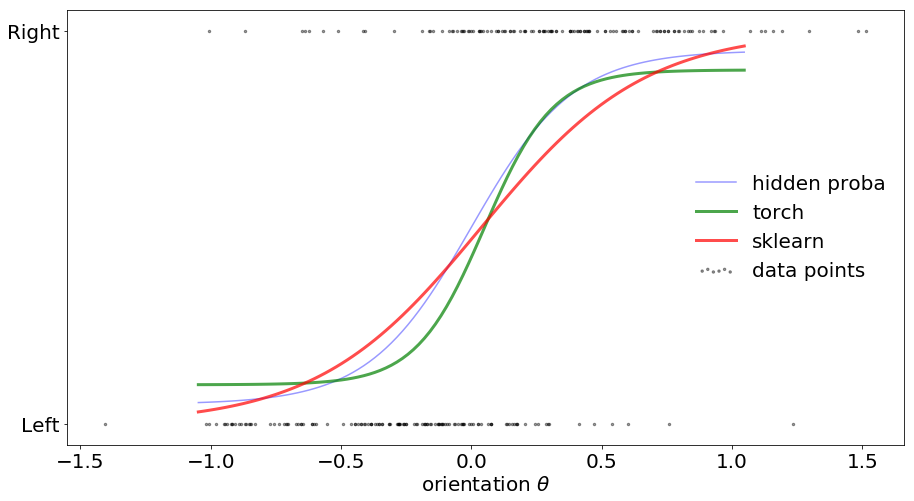

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(theta, y, s=6, alpha=0.4, color="k", label="data points")
# ax.scatter(theta, p, s=6, alpha=.4, color = 'b', label='hidden proba')
x_values = np.linspace(-2*theta_std, 2*theta_std, 100)[:, None]
y_values_p = psychometric_function(x_values, p0, theta0, wt)
ax.plot(x_values, y_values_p, alpha=0.4, color="b", label="hidden proba")
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
ax.plot(x_values, y_values, "g", alpha=0.7, lw=3, label="torch")
y_values_sk = logistic_model_sk.predict_proba(x_values)[:, 1]
ax.plot(x_values, y_values_sk, "r", alpha=0.7, lw=3, label="sklearn")
ax.set_xlabel(r"orientation $\theta$", fontsize=20)
ax.set_yticks([0.0, 1.0])
ax.set_yticklabels(["Left", "Right"], fontsize=20)
plt.legend(fontsize=20, frameon=False, scatterpoints=6);

There is a clear discrepency between the classical logistic function obtained by logistic regression (here, the implementation by `sklearn`) and that obtained by our more detailed model. In particular, the slope is more sharp, a feature which may be important for cognitive processes. But what is the origin of this discrepancy? Is it  the numerical optimization method? Is it the generative model?

This are the question we try to resolve here. First, let's retrieve a measure for how well the extracted psychometric curve represent the data: the *losses*.

In [18]:
theta, p, y = get_data(N=N_test, seed=seed + N_test)

In [19]:
logistic_model, loss = fit_data(theta, y, verbose=False)
print(f"Training loss = {loss:.3f}")

Training loss = 0.463


In [20]:
logistic_model_sk, loss_sk = fit_data_sklearn(theta, y, verbose=False)
print(f"Training sklearn loss = {loss_sk:.3f}")

Training sklearn loss = 0.470


The units for these losses are *bits*. Indeed, they represent some value of information about the binary data "$d$" and the continuous psychometric curve "$p$". This information is equal to $\log_2(p)$ if $d=1$ and $\log_2(1-p)$ if $d=0$. Putting things together, we obtain the [Binary Cross Entropy](https://pytorch.org/docs/stable/nn.html#bceloss) and if we index datapoints by $k$:

$$
\mathcal{L} = \sum_k d_k \cdot \log_2(p_k) + (1-d_k) \cdot \log_2(1-p_k)
$$

You can see that this measure is a form of [Cross_entropy](https://en.wikipedia.org/wiki/Cross_entropy), adapted to binary datapoints.

The losses which were computed above are those obtained during training. Relying on this value may be a dangerous strategy as the model may be overfitting the data. We should therefore measure how the model would generalize with novel data.

While it hard to do with real (experimental) data which are often scarse, here we synthesized the data and we can thus compute a testing loss by drawing again a set of new data and computing the loss on that data:

In [21]:
def loss_torch(logistic_model, theta, p, y):
    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])
    P = torch.Tensor(p[:, None])

    outputs = logistic_model(Theta)
    return criterion(outputs, labels).item() / len(theta)


print(f"Testing loss = {loss_torch(logistic_model, theta, p, y):.3f}")

Testing loss = 0.463


In [22]:
def loss_sklearn(logistic_model, theta, p, y):
    outputs = logistic_model.predict_proba(theta[:, None])[:, 1]
    outputs_, labels = torch.Tensor(outputs[:, None]), torch.Tensor(y[:, None])
    return criterion(outputs_, labels).item() / len(theta)


print(f"Testing sklearn loss = {loss_sklearn(logistic_model_sk, theta, p, y):.3f}")

Testing sklearn loss = 0.470


Finally, as we synthesized the data, we can compute the loss on that data with the "true" psychometric curve, giving to us the baseline number one can achieve:

In [23]:
def loss_true(theta, p, y):
    labels = torch.Tensor(y[:, None])
    P = torch.Tensor(p[:, None])
    return criterion(P, labels).item() / len(theta)


print(f"Testing true loss = {loss_true(theta, p, y):.3f}")

Testing true loss = 0.463



We are now equipped to make quantitative comparisons. Let's first explore the parameters of the methods.

## quantitative comparison of methods : varrying methods' parameters

Let's study the influence of each method's meta-parameter, such as the number of iterations. As I learn to use [python decorators](https://realpython.com/primer-on-python-decorators/#a-few-real-world-examples), I will use plenty of them:

In [24]:
import functools
import time

def timer(func):
    """Print the runtime of the decorated function"""
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        results = func(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return results
    return wrapper_timer

### influence of learning rate


In [25]:
default_dict = dict(learning_rate=learning_rate,
                    batch_size=batch_size,  # gamma=gamma,
                    num_epochs=num_epochs,
                    betas=betas,
                   N=N, p0=p0, theta0=theta0, wt=wt, theta_std=theta_std, seed=seed)

In [26]:
@timer
def explore_param(default_dict, variable, var_range, do_fit=True, do_SKL=True):
    results = np.zeros((4, len(var_range), N_cv))
    timings = []

    for i_var, var_ in enumerate(var_range):
        kwarg = default_dict.copy()
        kwarg[variable] = var_
        kwarg['verbose'] = False

        for i_CV in range(N_cv):
            
            kwarg.update(seed=seed + i_CV)
            theta, p, y = get_data(**kwarg)

            tic = time.time()
            if do_fit: logistic_model, loss = fit_data(theta, y, **kwarg)
            if do_SKL: logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, **kwarg)
            toc = time.time()

            if N_test > 0:
                kwarg.update(N=N_test, seed=seed + i_CV + N_test)
                theta, p, y = get_data(**kwarg)
                if do_fit: loss = loss_torch(logistic_model, theta, p, y)
                if do_SKL: loss_SKL = loss_sklearn(logistic_model_sk, theta, p, y)

            results[0, i_var, i_CV] = loss_true(theta, p, y)
            if do_fit: results[1, i_var, i_CV] = loss
            if do_SKL: results[2, i_var, i_CV] = loss_SKL
            results[3, i_var, i_CV] = toc-tic
            
        print(f"{variable}: {var_:.5f}, Loss: {np.mean(results[1, i_var, :]):.5f}, loss_P: {np.mean(results[0, i_var, :]):.5f}")

    return results
            

In [27]:
learning_rates = learning_rate * np.logspace(-2, 1, N_scan, base=10)
results = explore_param(default_dict, variable='learning_rate', var_range=learning_rates, do_SKL=False)

learning_rate: 0.00005, Loss: 0.46958, loss_P: 0.45867
learning_rate: 0.00012, Loss: 0.46375, loss_P: 0.45867
learning_rate: 0.00028, Loss: 0.46121, loss_P: 0.45867
learning_rate: 0.00067, Loss: 0.45978, loss_P: 0.45867
learning_rate: 0.00158, Loss: 0.45927, loss_P: 0.45867
learning_rate: 0.00375, Loss: 0.45940, loss_P: 0.45867
learning_rate: 0.00889, Loss: 0.45939, loss_P: 0.45867
learning_rate: 0.02108, Loss: 0.45923, loss_P: 0.45867
learning_rate: 0.05000, Loss: 0.45955, loss_P: 0.45867
Finished 'explore_param' in 1101.6187 secs


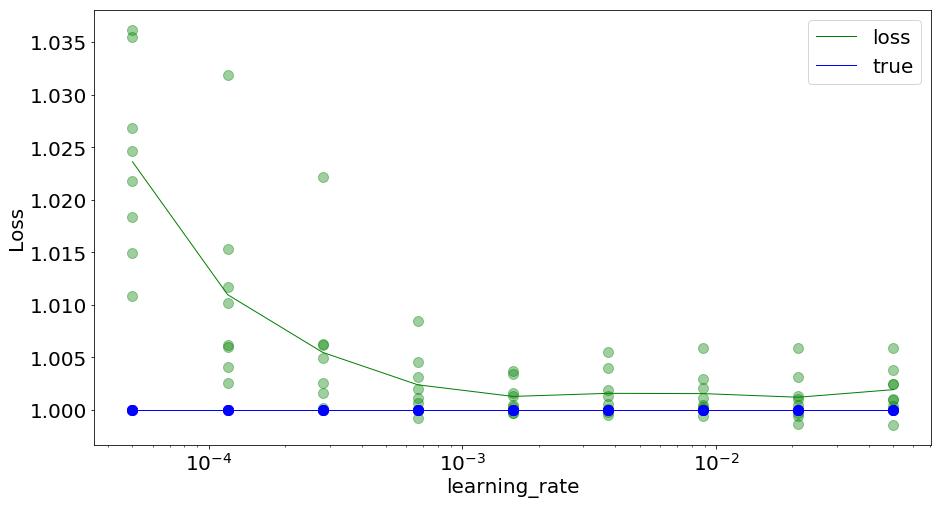

In [28]:
def plot_explore_param(variable, var_range, results):
    opts_scat = dict(marker=".", lw=0, alpha=3 / N_cv, ms=20)
    opts_line = dict(lw=1, alpha=1)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    if results[1, ...].sum()>0: ax.plot(var_range, results[1, :, :]/results[0, :, :], **opts_scat, color="green")
    ax.plot(var_range, results[0, :, :]/results[0, :, :], **opts_scat, color="blue")
    if results[2, ...].sum()>0: ax.plot(var_range, results[2, :, :]/results[0, :, :], **opts_scat, color="red")

    if results[1, ...].sum()>0: ax.plot(var_range, np.mean(results[1, :, :]/results[0, :, :], axis=-1), **opts_line, color="green", label="loss")
    ax.plot(var_range, np.mean(results[0, :, :]/results[0, :, :], axis=-1), **opts_line, color="blue", label="true")
    if results[2, ...].sum()>0: ax.plot(var_range, np.mean(results[2, :, :]/results[0, :, :], axis=-1), **opts_line, color="red", label="loss_SKL")

    # ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

    ax.set_xlabel(variable)
    ax.set_ylabel("Loss")
    ax.set_xscale("log")
    ax.legend(loc="best")
    return fig, ax

fig, ax = plot_explore_param(variable='learning_rate', var_range=learning_rates, results=results)

We are at a sweet spot with our learning rate, still it is valid on a wide range. 

### influence du nombre d'epochs

In [29]:
num_epochss = num_epochs * np.logspace(-2, 1, N_scan, base=10)
num_epochss = [int(num_epochs_) for num_epochs_ in num_epochss]

results = explore_param(default_dict, variable='num_epochs', var_range=num_epochss, do_SKL=False)

num_epochs: 5.00000, Loss: 0.46924, loss_P: 0.45867
num_epochs: 12.00000, Loss: 0.46356, loss_P: 0.45867
num_epochs: 28.00000, Loss: 0.46118, loss_P: 0.45867
num_epochs: 68.00000, Loss: 0.45963, loss_P: 0.45867
num_epochs: 162.00000, Loss: 0.45923, loss_P: 0.45867
num_epochs: 384.00000, Loss: 0.45938, loss_P: 0.45867
num_epochs: 912.00000, Loss: 0.45939, loss_P: 0.45867
num_epochs: 2163.00000, Loss: 0.45946, loss_P: 0.45867
num_epochs: 5130.00000, Loss: 0.45938, loss_P: 0.45867
Finished 'explore_param' in 2154.0556 secs


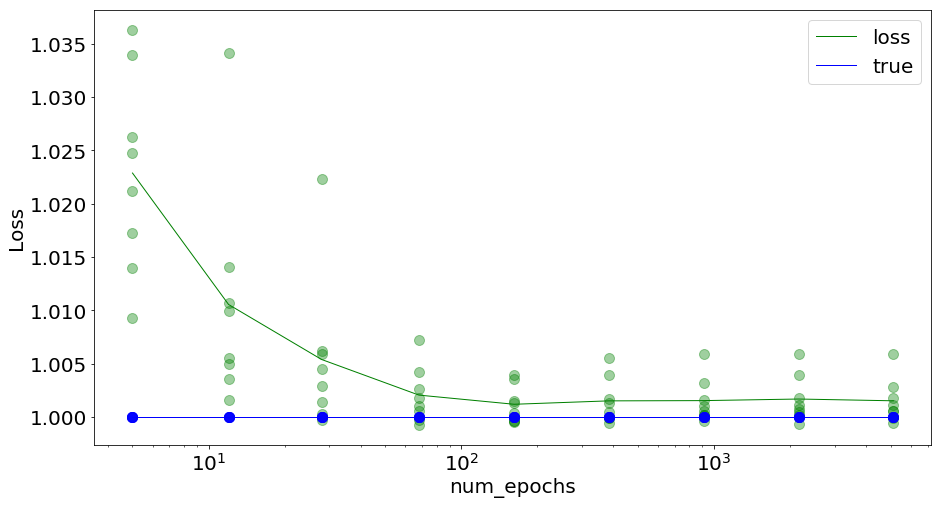

In [30]:
fig, ax = plot_explore_param(variable='num_epochs', var_range=num_epochss, results=results)

Similarly, we are at a sweet spot with our number of epochs, and this is true for both methods. 

### influence of minibatch size

In [31]:
import time

In [32]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes = [int(batch_size_) for batch_size_ in batch_sizes]

results = explore_param(default_dict, variable='batch_size', var_range=batch_sizes, do_SKL=False)

batch_size: 32.00000, Loss: 0.45904, loss_P: 0.45867
batch_size: 41.00000, Loss: 0.45968, loss_P: 0.45867
batch_size: 53.00000, Loss: 0.45926, loss_P: 0.45867
batch_size: 69.00000, Loss: 0.45932, loss_P: 0.45867
batch_size: 90.00000, Loss: 0.45940, loss_P: 0.45867
batch_size: 117.00000, Loss: 0.45944, loss_P: 0.45867
batch_size: 152.00000, Loss: 0.45925, loss_P: 0.45867
batch_size: 197.00000, Loss: 0.45936, loss_P: 0.45867
batch_size: 256.00000, Loss: 0.45936, loss_P: 0.45867
Finished 'explore_param' in 1894.8878 secs


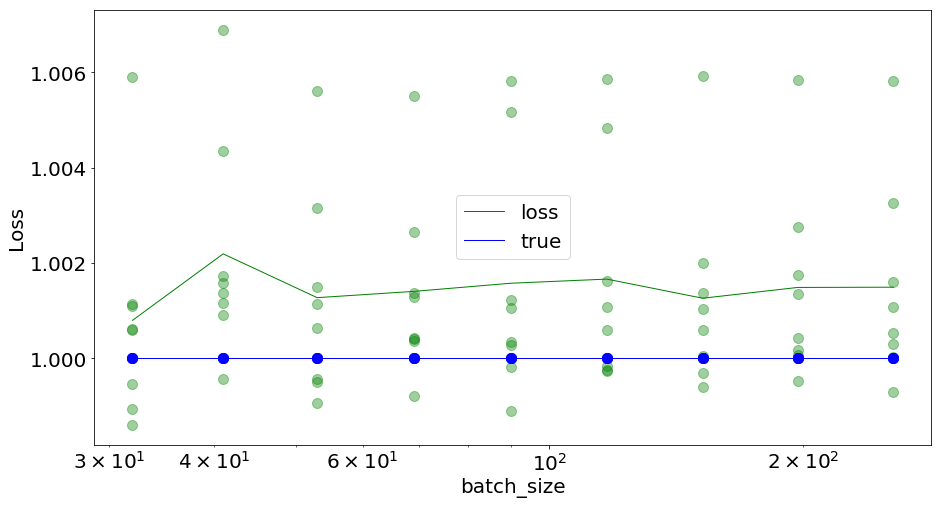

In [33]:
fig, ax = plot_explore_param(variable='batch_size', var_range=batch_sizes, results=results)

As expected, `batch_size` as minor effects on the cost, but it can on the CPU time:

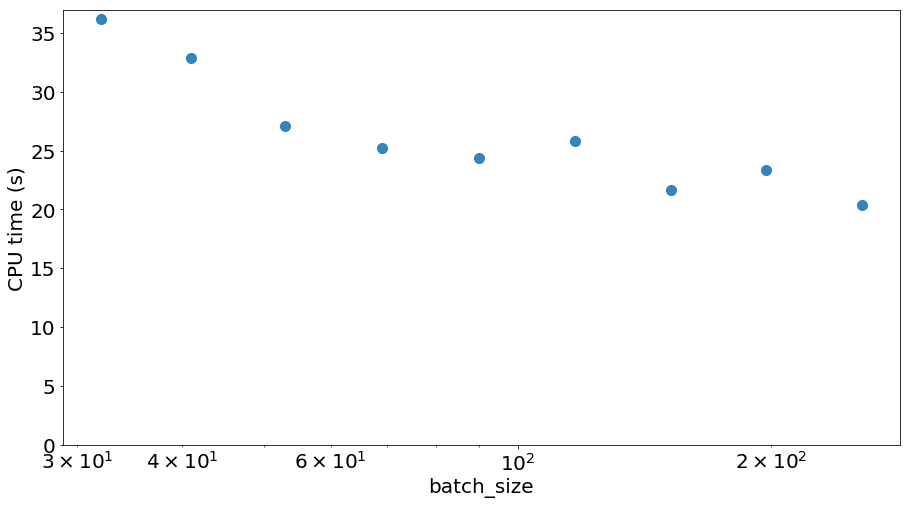

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))
opts_scat = dict(marker=".", lw=0, alpha=.9, ms=20)
ax.plot(batch_sizes, np.mean(results[3, :, :], axis=-1), **opts_scat)
ax.set_xlabel("batch_size")
ax.set_ylabel("CPU time (s)")
ax.set_ylim(0)
ax.set_xscale("log");

### influence of `beta1`

In [35]:
beta1s = 1.0 - np.logspace(-3, -2, N_scan, base=10, endpoint=True)
results = explore_param(default_dict, variable='beta1', var_range=beta1s, do_SKL=False)

beta1: 0.99900, Loss: 0.45940, loss_P: 0.45867
beta1: 0.99867, Loss: 0.45942, loss_P: 0.45867
beta1: 0.99822, Loss: 0.45946, loss_P: 0.45867
beta1: 0.99763, Loss: 0.45943, loss_P: 0.45867
beta1: 0.99684, Loss: 0.45942, loss_P: 0.45867
beta1: 0.99578, Loss: 0.45938, loss_P: 0.45867
beta1: 0.99438, Loss: 0.45946, loss_P: 0.45867
beta1: 0.99250, Loss: 0.45937, loss_P: 0.45867
beta1: 0.99000, Loss: 0.45939, loss_P: 0.45867
Finished 'explore_param' in 1476.7868 secs


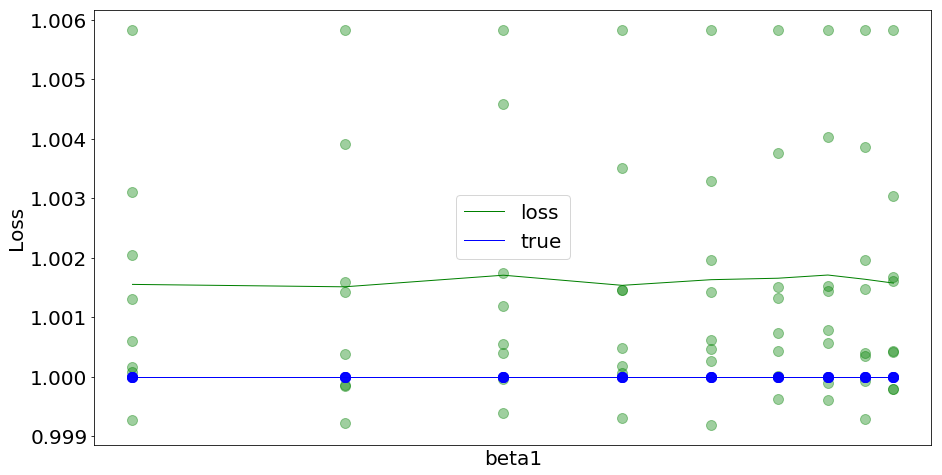

In [36]:
fig, ax = plot_explore_param(variable='beta1', var_range=beta1s, results=results)

The influence of this parameter is limited, such that using `Adam` is perhaps overkill. A simple `SGD` should be tested. Similarly, for `beta2`:

### influence of `beta2`

In [37]:
beta2s = 1.0 - np.logspace(-7, -2, N_scan, base=10, endpoint=True)
results = explore_param(default_dict, variable='beta2', var_range=beta2s, do_SKL=False)

beta2: 1.00000, Loss: 0.45933, loss_P: 0.45867
beta2: 1.00000, Loss: 0.45940, loss_P: 0.45867
beta2: 1.00000, Loss: 0.45942, loss_P: 0.45867
beta2: 0.99999, Loss: 0.45933, loss_P: 0.45867
beta2: 0.99997, Loss: 0.45932, loss_P: 0.45867
beta2: 0.99987, Loss: 0.45934, loss_P: 0.45867
beta2: 0.99944, Loss: 0.45943, loss_P: 0.45867
beta2: 0.99763, Loss: 0.45944, loss_P: 0.45867
beta2: 0.99000, Loss: 0.45934, loss_P: 0.45867
Finished 'explore_param' in 1464.4270 secs


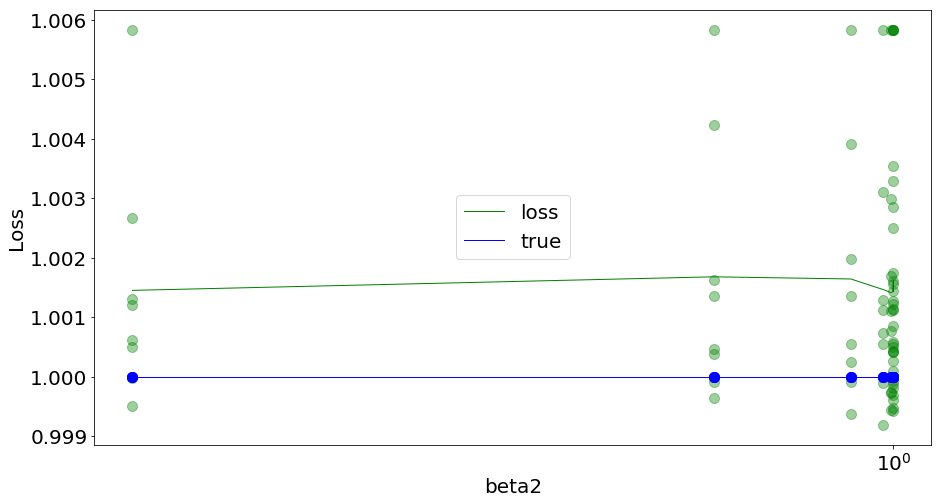

In [38]:
fig, ax = plot_explore_param(variable='beta2', var_range=beta2s, results=results)

### influence of `C`

In [39]:
Cs = C * np.logspace(-2, 2, N_scan, base=4)
results = explore_param(default_dict, variable='C', var_range=Cs, do_fit=False)

C: 0.18750, Loss: 0.00000, loss_P: 0.45867
C: 0.37500, Loss: 0.00000, loss_P: 0.45867
C: 0.75000, Loss: 0.00000, loss_P: 0.45867
C: 1.50000, Loss: 0.00000, loss_P: 0.45867
C: 3.00000, Loss: 0.00000, loss_P: 0.45867
C: 6.00000, Loss: 0.00000, loss_P: 0.45867
C: 12.00000, Loss: 0.00000, loss_P: 0.45867
C: 24.00000, Loss: 0.00000, loss_P: 0.45867
C: 48.00000, Loss: 0.00000, loss_P: 0.45867
Finished 'explore_param' in 0.4555 secs


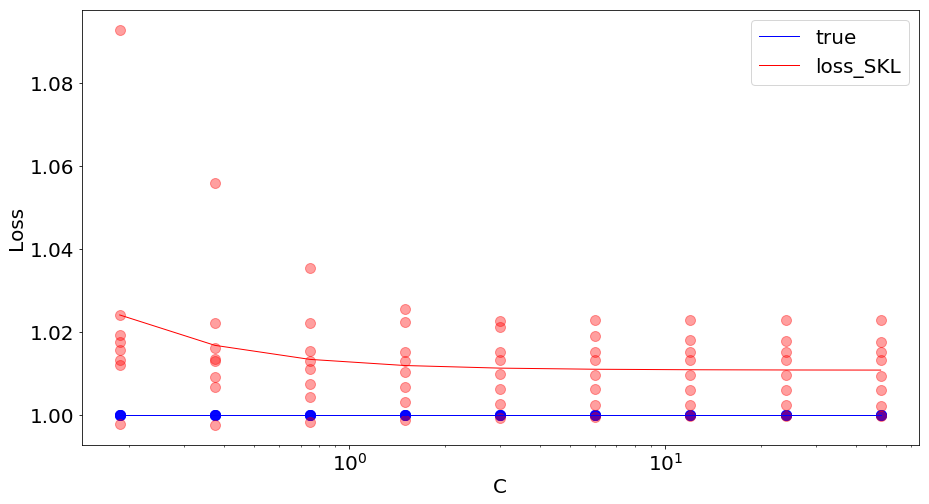

In [40]:
fig, ax = plot_explore_param(variable='C', var_range=Cs, results=results)

### influence of `tol`

In [41]:
tols = tol * np.logspace(-2, 2, N_scan, base=10)
results = explore_param(default_dict, variable='tol', var_range=tols, do_fit=False)

tol: 0.00000, Loss: 0.00000, loss_P: 0.45867
tol: 0.00000, Loss: 0.00000, loss_P: 0.45867
tol: 0.00000, Loss: 0.00000, loss_P: 0.45867
tol: 0.00000, Loss: 0.00000, loss_P: 0.45867
tol: 0.00001, Loss: 0.00000, loss_P: 0.45867
tol: 0.00003, Loss: 0.00000, loss_P: 0.45867
tol: 0.00010, Loss: 0.00000, loss_P: 0.45867
tol: 0.00032, Loss: 0.00000, loss_P: 0.45867
tol: 0.00100, Loss: 0.00000, loss_P: 0.45867
Finished 'explore_param' in 0.2748 secs


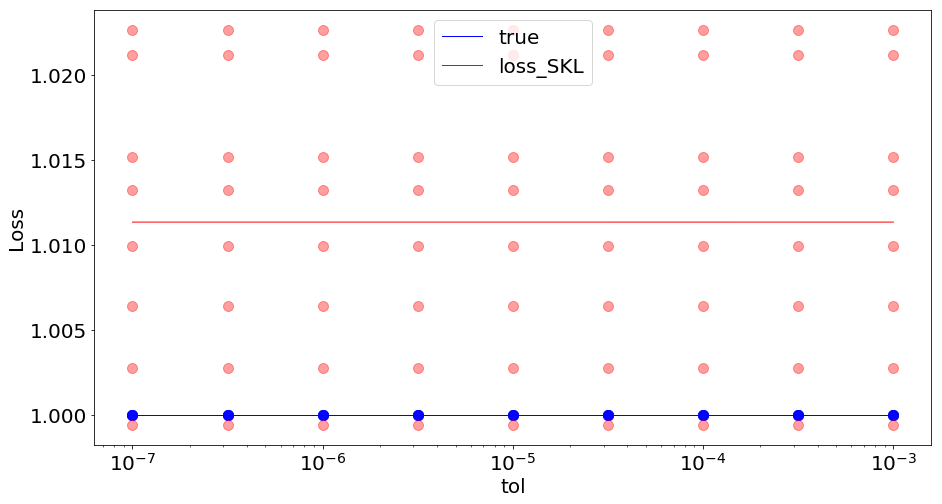

In [42]:
fig, ax = plot_explore_param(variable='tol', var_range=tols, results=results)


## quantitative comparison of methods : varrying experimental parameters

Now that we now more about methodological parameters, let's study more crucial parameters like that of the experiment.


### influence of number of trials

The number of trials is crucial as if defines the number of our datapoints, and also the length of the experiment. This is important as we want to make this number as low as possible. Indeed, observers doing the experiment, for example a master student in front of the computer screen, may experience fatigue which would prevent accurate recordings.

In [43]:
Ns = np.logspace(1.5, 3, N_scan, base=10, endpoint=True)
Ns = [int(Ns_) for Ns_ in Ns]

results = explore_param(default_dict, variable='N', var_range=Ns)

N: 31.00000, Loss: 0.46367, loss_P: 0.45867
N: 48.00000, Loss: 0.46928, loss_P: 0.45867
N: 74.00000, Loss: 0.46019, loss_P: 0.45867
N: 115.00000, Loss: 0.45996, loss_P: 0.45867
N: 177.00000, Loss: 0.46061, loss_P: 0.45867
N: 273.00000, Loss: 0.45981, loss_P: 0.45867
N: 421.00000, Loss: 0.45919, loss_P: 0.45867
N: 649.00000, Loss: 0.45907, loss_P: 0.45867
N: 1000.00000, Loss: 0.45933, loss_P: 0.45867
Finished 'explore_param' in 1385.3615 secs


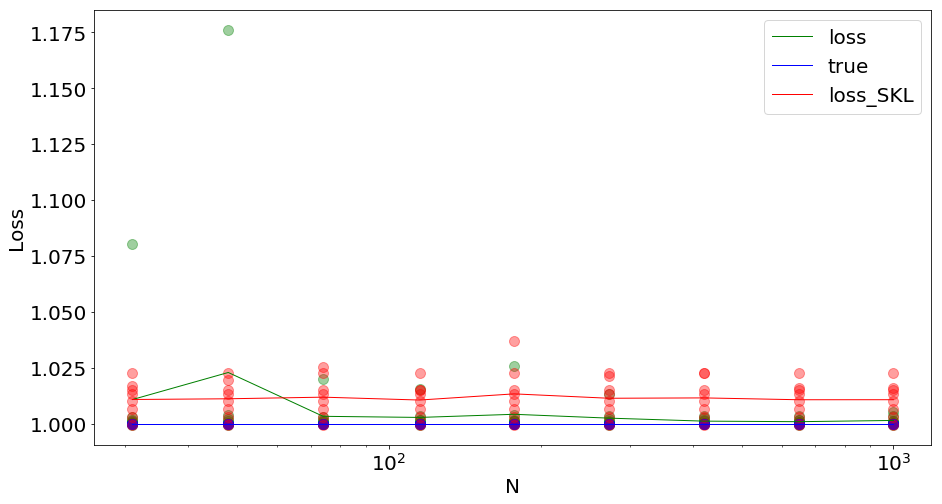

In [44]:
fig, ax = plot_explore_param(variable='N', var_range=Ns, results=results)

As a consequence, $20$ trials is not enough and $100$ is OK. This depends on our expectations on the the retrieved data.

### influence of theta_std

The convergence of the fitting procedure may also depend on the parametrers of the data which were set to:

In [45]:
print(
    f"p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}"
)

p0 = 0.100, theta0 = 0.000, wt = 0.196, theta_std = 0.524


One of this is `theta_std` and is describing the "width" of tested orientation values:

In [46]:
theta_stds = theta_std * np.logspace(-1, 1, N_scan, base=2, endpoint=True)

results = explore_param(default_dict, variable='theta_std', var_range=theta_stds)

theta_std: 0.26180, Loss: 0.58582, loss_P: 0.58524
theta_std: 0.31133, Loss: 0.55833, loss_P: 0.55770
theta_std: 0.37024, Loss: 0.52453, loss_P: 0.52427
theta_std: 0.44029, Loss: 0.49218, loss_P: 0.49125
theta_std: 0.52360, Loss: 0.45939, loss_P: 0.45867
theta_std: 0.62267, Loss: 0.42651, loss_P: 0.42621
theta_std: 0.74048, Loss: 0.39693, loss_P: 0.39641
theta_std: 0.88058, Loss: 0.37132, loss_P: 0.37036
theta_std: 1.04720, Loss: 0.34486, loss_P: 0.34385
Finished 'explore_param' in 1534.1578 secs


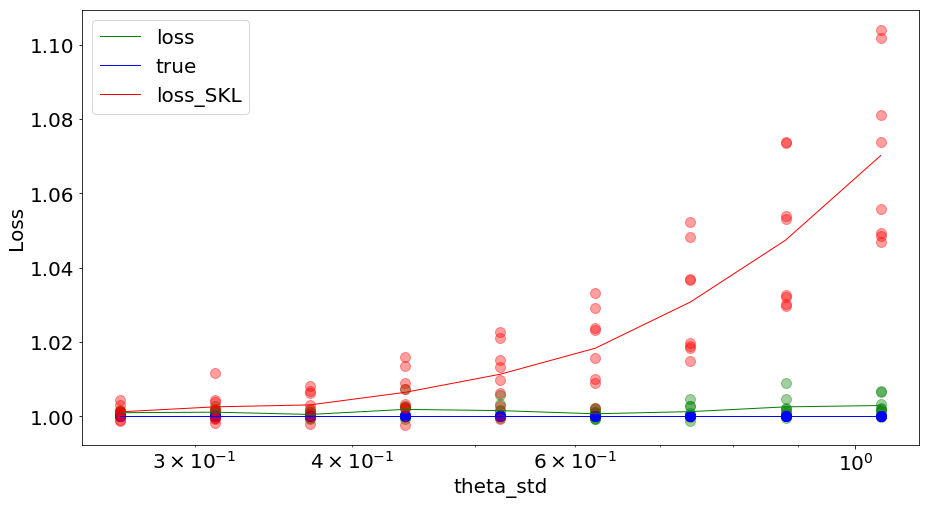

In [47]:
fig, ax = plot_explore_param(variable='theta_std', var_range=theta_stds, results=results)

The value of  `theta_std` as a clear influence on the loss in particular for classical logistic regression (`sklearn`) which will have a problem with datapoints caused by the lapse rate `p0`.

### influence of `p0`



In [48]:
p0s = np.logspace(-3, -0.7, N_scan, base=10, endpoint=True)

results = explore_param(default_dict, variable='p0', var_range=p0s)


p0: 0.00100, Loss: 0.39161, loss_P: 0.39098
p0: 0.00194, Loss: 0.39261, loss_P: 0.39202
p0: 0.00376, Loss: 0.39395, loss_P: 0.39339
p0: 0.00729, Loss: 0.39561, loss_P: 0.39513
p0: 0.01413, Loss: 0.40088, loss_P: 0.40054
p0: 0.02738, Loss: 0.41109, loss_P: 0.41050
p0: 0.05309, Loss: 0.42761, loss_P: 0.42731
p0: 0.10292, Loss: 0.46081, loss_P: 0.46014
p0: 0.19953, Loss: 0.51878, loss_P: 0.51765
Finished 'explore_param' in 1492.0474 secs


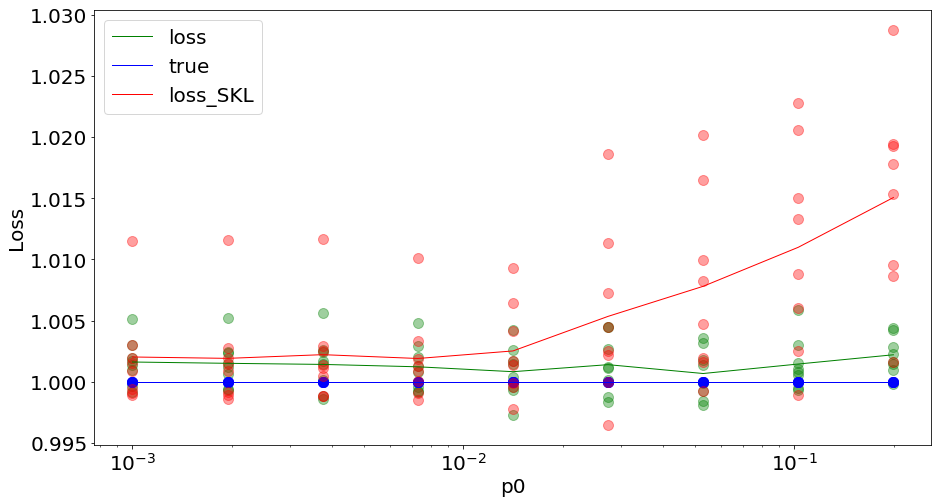

In [49]:
fig, ax = plot_explore_param(variable='p0', var_range=p0s, results=results)

As expected, the lapse rate `p0`as an influence on the cost: when low ($p0<0.01$), cost are similar. When higher, the two methods diverge and our method is obviously better.

After this quantitative comparison of the methods, let's now study how the methods compare when retrieving the parameters.

## comparing the predicted values

In this section, we will change one parameter after antoher, while keeping the others fixed and check the retrieved value obtained by both methods.


In [50]:
print(
    f"p0 = {p0:.3f}, theta0 = {theta0:.3f}, wt = {wt:.3f}, theta_std = {theta_std:.3f}"
)

p0 = 0.100, theta0 = 0.000, wt = 0.196, theta_std = 0.524




### changing `p0`

Let's start by changing the lapse rate `p0`:

In [51]:
N_scan = 20
p0s = np.logspace(-3, -0.7, N_scan, base=10, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for p0_ in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(p0=p0_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)

        p0s_.append(p0_)
        theta0s_.append(theta0)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)

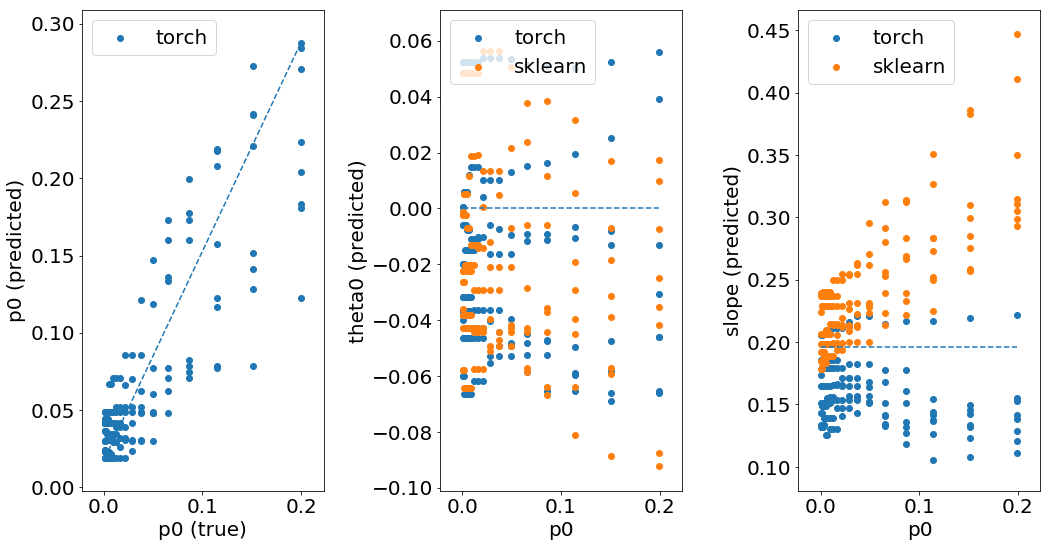

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(p0s_, p0_tos, label="torch")
axs[0].plot([min(p0s_), max(p0s_)], [min(p0_tos), max(p0_tos)], "--")
axs[0].set(xlabel="p0 (true)", ylabel="p0 (predicted)")
axs[0].legend(loc="upper left")

axs[1].scatter(p0s_, theta0_tos, label="torch")
axs[1].scatter(p0s_, theta0_sks, label="sklearn")
axs[1].plot([min(p0s_), max(p0s_)], [theta0, theta0], "--")
axs[1].set(xlabel="p0", ylabel="theta0 (predicted)")
axs[1].legend(loc="upper left")

axs[2].scatter(p0s_, wt_tos, label="torch")
axs[2].scatter(p0s_, wt_sks, label="sklearn")
axs[2].plot([min(p0s_), max(p0s_)], [wt, wt], "--")
axs[2].set(xlabel="p0", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();

Our method is able to fairly accurately retrieve the value of the lapse rate. The errors obtained in the fitting of the other parameters are comparable forr `theta0`but are high on the slope. The slope is clearly overestimated depending on the lapse rate. 



### changing `theta0`


In [53]:
N_scan = 20
theta0s = .61803 * theta_std * np.linspace(-1, 1, N_scan, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for theta0_ in theta0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(theta0=theta0_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0_)
        wts_.append(wt)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)

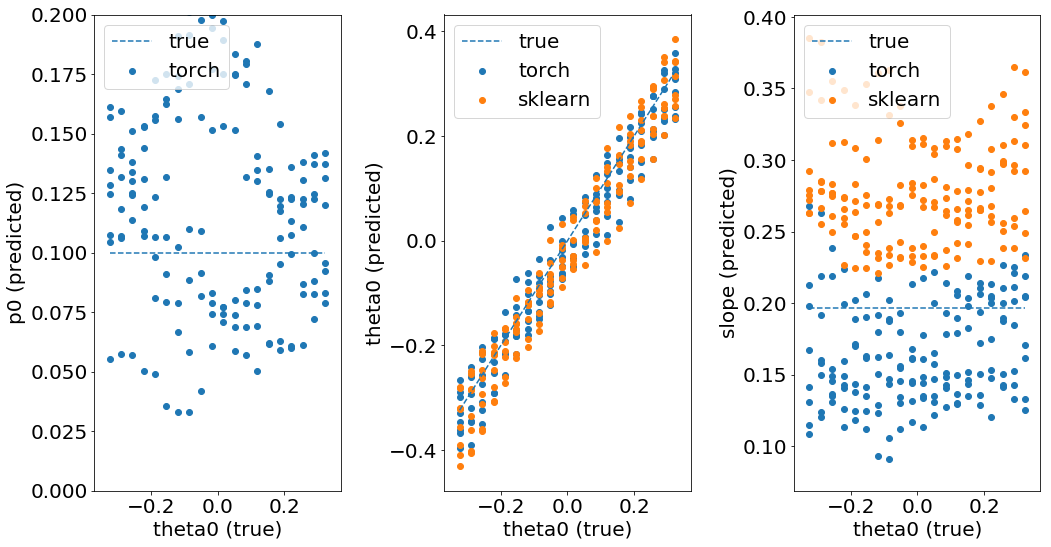

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(theta0s_, p0_tos, label="torch")
axs[0].plot([min(theta0s_), max(theta0s_)], [p0, p0], "--", label="true")
axs[0].set(xlabel="theta0 (true)", ylabel="p0 (predicted)", ylim=(.0, .2))
axs[0].legend(loc="upper left")

axs[1].scatter(theta0s_, theta0_tos, label="torch")
axs[1].scatter(theta0s_, theta0_sks, label="sklearn")
axs[1].plot([min(theta0s_), max(theta0s_)], [min(theta0s_), max(theta0s_)], "--", label="true")
axs[1].set(xlabel="theta0 (true)", ylabel="theta0 (predicted)")
axs[1].legend(loc="upper left")

axs[2].scatter(theta0s_, wt_tos, label="torch")
axs[2].scatter(theta0s_, wt_sks, label="sklearn")
axs[2].plot([min(theta0s_), max(theta0s_)], [wt, wt], "--", label="true")
axs[2].set(xlabel="theta0 (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();



### changing `wt`


In [55]:
N_scan = 20
wts = wt * np.logspace(-1, .5, N_scan, base=4, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for wt_ in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wt_, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0)
        wts_.append(wt_)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)

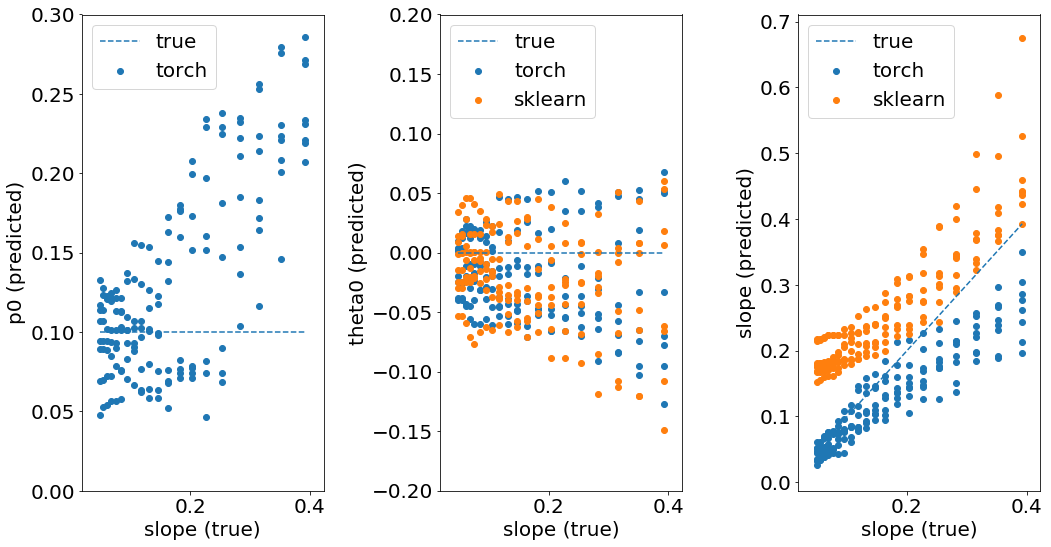

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(wts_, p0_tos, label="torch")
axs[0].plot([min(wts_), max(wts_)], [p0, p0], "--", label="true")
axs[0].set(xlabel="slope (true)", ylabel="p0 (predicted)", ylim=(.0, .3))
axs[0].legend(loc="upper left")

axs[1].scatter(wts_, theta0_tos, label="torch")
axs[1].scatter(wts_, theta0_sks, label="sklearn")
axs[1].plot([min(wts_), max(wts_)], [theta0, theta0], "--", label="true")
axs[1].set(xlabel="slope (true)", ylabel="theta0 (predicted)", ylim=(-.2, .2))
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label="torch")
axs[2].scatter(wts_, wt_sks, label="sklearn")
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], "--", label="true")
axs[2].set(xlabel="slope (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();

Our method is able to fairly accurately retrieve the value of the lapse rate, but the precision decreases with the lapse rate. The errors obtained in the fitting of the other parameters are comparable forr `theta0` but are high on the slope. The slope is clearly overestimated in the case of the classical logistic regression. 


### changing `wt` with a null lapse rate (`p0=0`)

Let's decompose the effect of using `torch` to using `sklearn`


In [57]:
N_scan = 20
wts = wt * np.logspace(-1, .5, N_scan, base=4, endpoint=True)

p0s_, wts_, theta0s_, p0_tos, theta0_tos, theta0_sks, wt_tos, wt_sks = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for wt_ in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(wt=wt_, p0=0, seed=seed + i_CV)

        logistic_model, loss = fit_data(theta, y, verbose=False)
        logistic_model_sk, loss_SKL = fit_data_sklearn(theta, y, verbose=False)

        theta0_to, wt_to, p0_to = get_params(logistic_model, verbose=False)
        theta0_sk, wt_sk = get_params_sk(logistic_model_sk, verbose=False)

        p0s_.append(p0)
        theta0s_.append(theta0)
        wts_.append(wt_)
        p0_tos.append(p0_to)
        theta0_tos.append(theta0_to)
        theta0_sks.append(theta0_sk)
        wt_tos.append(wt_to)
        wt_sks.append(wt_sk)

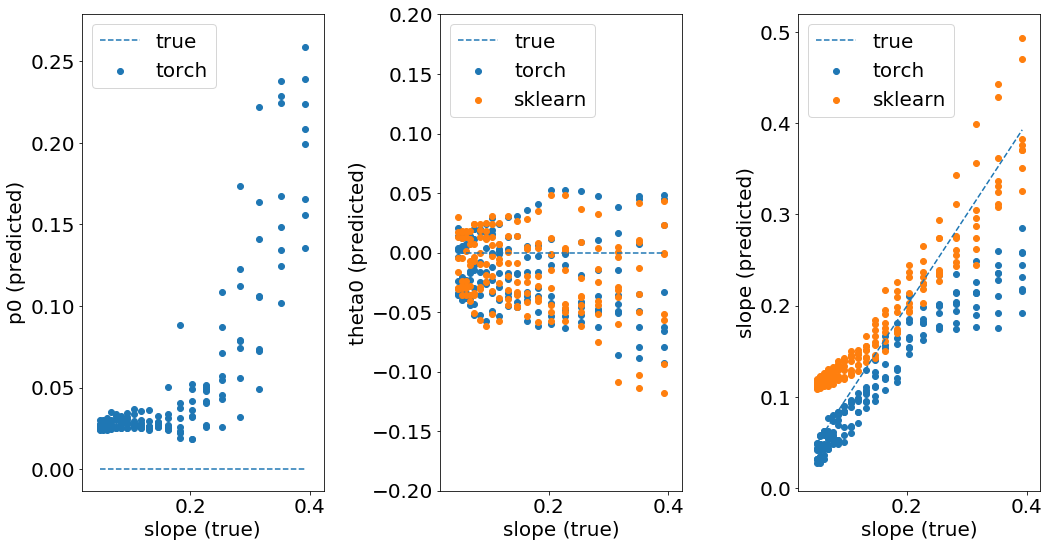

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

axs[0].scatter(wts_, p0_tos, label="torch")
axs[0].plot([min(wts_), max(wts_)], [0, 0], "--", label="true")
axs[0].set(xlabel="slope (true)", ylabel="p0 (predicted)")
axs[0].legend(loc="upper left")

axs[1].scatter(wts_, theta0_tos, label="torch")
axs[1].scatter(wts_, theta0_sks, label="sklearn")
axs[1].plot([min(wts_), max(wts_)], [theta0, theta0], "--", label="true")
axs[1].set(xlabel="slope (true)", ylabel="theta0 (predicted)", ylim=(-.2, .2))
axs[1].legend(loc="upper left")

axs[2].scatter(wts_, wt_tos, label="torch")
axs[2].scatter(wts_, wt_sks, label="sklearn")
axs[2].plot([min(wts_), max(wts_)], [min(wts_), max(wts_)], "--", label="true")
axs[2].set(xlabel="slope (true)", ylabel="slope (predicted)")
axs[2].legend(loc="upper left")
plt.tight_layout();

This again shows that the slope is better matched with the method presented in this notebook. 

In [59]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,sklearn,matplotlib  -r -g -b

2020-04-17T20:12:09+02:00

CPython 3.7.7
IPython 7.13.0

numpy 1.18.2
torch 1.4.0
sklearn 0.22.2.post1
matplotlib 3.2.1

compiler   : Clang 11.0.0 (clang-1100.0.33.17)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : ekla
Git hash   : 2bcf45e375340446b49f92be8080463712f4e3d7
Git repo   : https://github.com/jennafradin/MSc-Internship.git
Git branch : master
